In [513]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import itertools
from matplotlib import cm

fb = pd.read_csv('data/fb_stock_prices_2018.csv', index_col='date', parse_dates=True)

quakes = pd.read_csv('data/earthquakes.csv')

covid = pd.read_csv('data/covid19_cases.csv', index_col='dateRep', parse_dates=True, dayfirst=True)
covid.replace(to_replace={'United_States_of_America': 'USA'}, inplace=True)

In [189]:
# !head -2 data/covid19_cases.csv

dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
19/09/2020,19,9,2020,47,1,Afghanistan,AF,AFG,38041757.0,Asia,1.61664457


## Exercise 1

Using **seaborn**, create a heatmap to visualize the correlation coefficients between earthquake magnitude and whether there was a tsunami for earthquakes measured with the **mb** magnitude type.

In [5]:
quakes.head(3)

,mag,magType,time,place,tsunami,parsed_place
0,1.35,ml,1539475168010,"9km NE of Aguanga, CA",0,California
1,1.29,ml,1539475129610,"9km NE of Aguanga, CA",0,California
2,3.42,ml,1539475062610,"8km NE of Aguanga, CA",0,California


In [17]:
q2 = (quakes.query('magType == "mb"')
      .loc[:, ['mag', 'tsunami']]
     )

(array([0.5, 1.5]), [Text(0, 0.5, 'mag'), Text(0, 1.5, 'tsunami')])

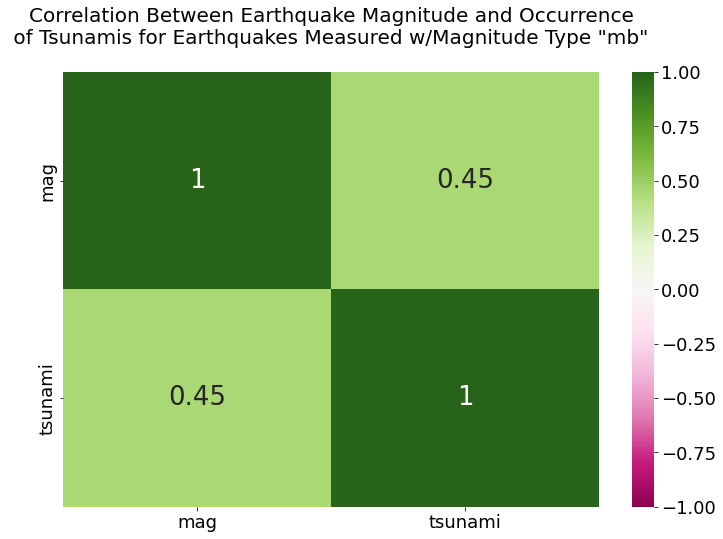

In [90]:
fig, ax = plt.subplots(figsize=(12,8))  ## THIS CONSTRUCTION IS WORTH A NOTE...TIED TO PASSING THE AX ARGUMENT TO THE PLOTTING FUNCTION

sns.heatmap(
    q2.corr(),
    annot=True,
    center = 0,
    vmin=-1,
    vmax=1,
    ax=ax, ############  THIS IS KEY TO USING THE figure AND ax CREATED ABOVE WITH THE figsize YOU WANT
    annot_kws={'size': 26},
    cmap='PiYG'
)

plt.title('Correlation Between Earthquake Magnitude and Occurrence\n of Tsunamis for Earthquakes Measured w/Magnitude Type "mb" \n',
          fontdict = {'fontsize' : 20})

plt.xticks(size = 18)
plt.yticks(size = 18)


In [86]:
### plt.rcParams.keys() # USEFUL FOR SEEING THE PARAMETER OPTIONS FOR MATPLOTLIB

## Exercise 2

Create a box plot of Facebook volume traded and closing prices, and draw reference lines for the bounds of a Tukey fence with a multiplier of 1.5. The bounds will be at Q1 − 1.5 × IQR and Q3 + 1.5 × IQR. Be sure to use the quantile() method on the data to make this easier. (Pick whichever orientation you prefer for the plot, but make sure to use subplots.)


In [133]:
quantiles = fb[['volume', 'close']].quantile([.25, .50, .75])
quantiles

,volume,close
0.25,17828394.0,157.915
0.50,21860931.0,174.700
0.75,30313840.0,185.270


**HOW TO ADD A ROW. I HADN'T THOUGHT OF HOW TO DO THIS DIRECTLY.**

In [148]:
quantiles.loc['iqr', :] = quantiles.loc[.75, :] - quantiles.loc[.25, :]

In [149]:
quantiles

,volume,close
0.25,17828394.0,157.915
0.5,21860931.0,174.700
0.75,30313840.0,185.270
iqr,12485446.0,27.355


In [145]:
IQR = (quantiles.loc[.75,:] - quantiles.loc[.25,:]).to_frame()
IQR

,0
volume,1.248545e+07
close,2.735500e+01


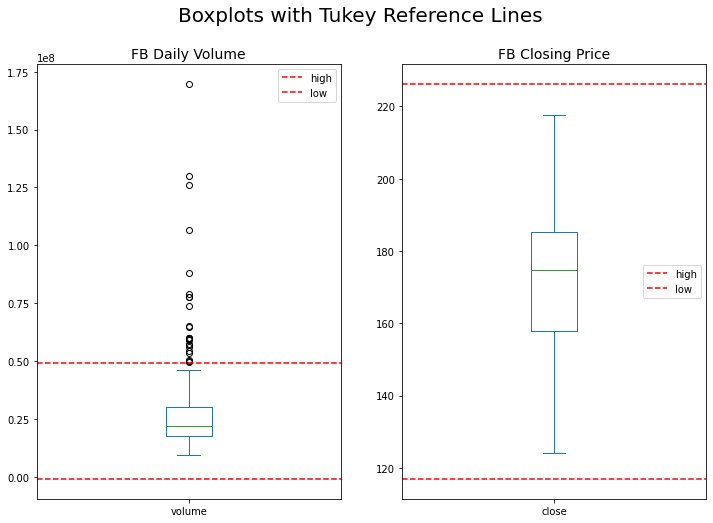

In [341]:
cols = ['volume', 'close']
titles = ['FB Daily Volume', 'FB Closing Price']

axes = fb[cols].plot(kind='box', subplots=True, layout=(1,2), figsize=(12,8))

for ax, col, title in zip(axes, cols, titles):
    ax.set_title(title, size=14)
    low = quantiles.loc[0.25, col] - 1.5*quantiles.loc['iqr', col]
    high = quantiles.loc[0.75, col] + 1.5*quantiles.loc['iqr', col]
    ax.axhline(y=low, color='r', linestyle='--', label='high')
    ax.axhline(y=high, color='r', linestyle='--', label='low')
    ax.legend()
    
plt.suptitle("Boxplots with Tukey Reference Lines\n", size=20)
None

volume    AxesSubplot(0.125,0.536818;0.775x0.343182)
close        AxesSubplot(0.125,0.125;0.775x0.343182)
dtype: object

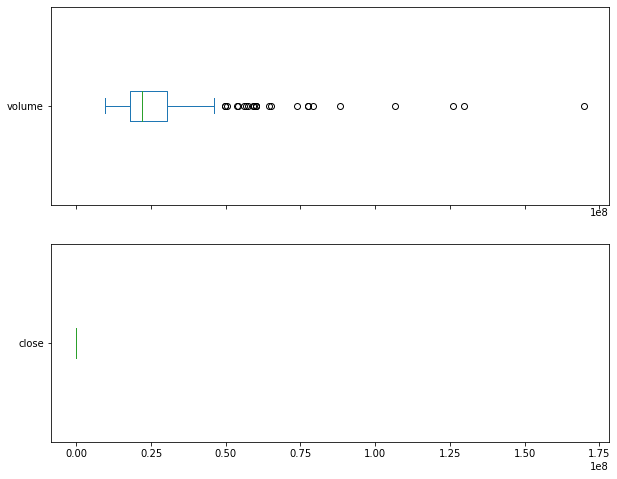

In [336]:
fb[['volume', 'close']].plot(kind='box', subplots=True, layout=(2,1), figsize=(10,8), vert=False)


## Exercise 3

Plot the evolution of cumulative COVID-19 cases worldwide, and add a dashed vertical line on the date that it surpassed 1 million. Be sure to format the tick labels on the y-axis accordingly.

In [191]:
covid.head(3)

,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
dateRep,,,,,,,,,,,
2020-09-19,19,9,2020,47,1,Afghanistan,AF,AFG,38041757.0,Asia,1.616645
2020-09-18,18,9,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,1.535155
2020-09-17,17,9,2020,17,0,Afghanistan,AF,AFG,38041757.0,Asia,1.653446


In [285]:
from matplotlib.ticker import EngFormatter
import matplotlib.ticker

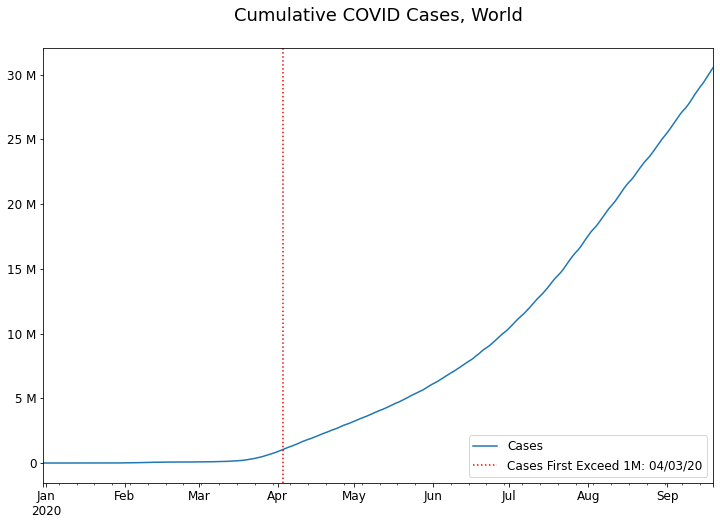

In [296]:
cumcases = (covid
    .groupby(pd.Grouper(freq='D'))
    .agg({'cases': 'sum'})  ### AGGREGATES CASES BY DAY
    .cumsum() ### AGGREGATES DAILY CASES INTO CUMULATIVE CASES
    .sort_index()
    .rename({'cases':'Cases'}, axis=1)
           )

million_day = cumcases.query('Cases > 1E6').index.min() # FIRST DAY CASES EXCEED 1M

ax =(cumcases
 .plot(kind='line', figsize=(12,8)) 
 .axvline(x=million_day, linestyle=':', color='r', label=f"Cases First Exceed 1M: {million_day:%m/%d/%y}")
)


plt.title("Cumulative COVID Cases, World\n", size=18)
plt.xlabel("")
plt.xticks(size=12)
plt.yticks(size=12)
plt.legend(fontsize = 12)

ax.axes.yaxis.set_major_formatter(EngFormatter()) # I DON'T UNDERSTAND WHY IT'S ax.axes.yaxis 
                                                  # INSTEAD OF ax.yaxis


## Exercise 4

Use `axvspan()` to shade a rectangle from '2018-07-25' to '2018-07-31', which marks the large decline in Facebook price on a line plot of the closing price.

In [297]:
fb.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


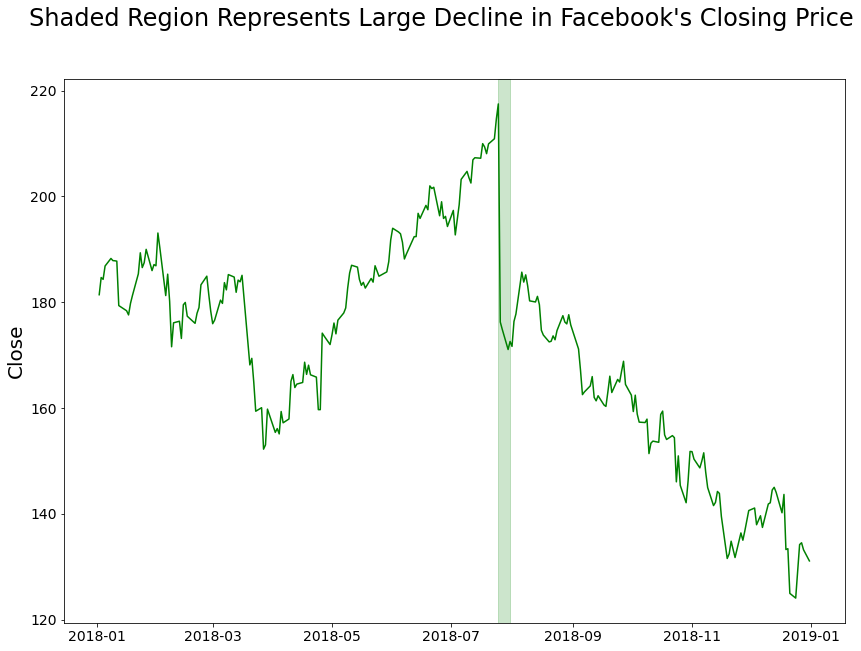

In [334]:
fig, ax = plt.subplots(figsize = (14,10))

sns.lineplot(data=fb.close, ax=ax, color='g')
ax.axvspan(
    '2018-07-25',
    '2018-07-31',
    alpha=0.2,
    color='g'
)

plt.suptitle("Shaded Region Represents Large Decline in Facebook's Closing Price", size=24)
plt.ylabel("Close", size=20)
plt.xlabel("")
plt.xticks(size=14)
plt.yticks(size=14)

# USEFUL! SUPPRESSES SUPERFLUOUS TEXT OUTPUT

None    

## Exercise 5

Using the Facebook stock price data, annotate the following three events on a line plot of the closing price: 

- Disappointing user growth announced after close on July 25, 2018  

- Cambridge Analytica story breaks on March 19, 2018 (when it affected the market)  

- FTC launches investigation on March 20, 2018

In [491]:
pd.Series(['2018-07-25'], dtype ='datetime64[ns]') + pd.DateOffset(days=3)

0   2018-07-28
dtype: datetime64[ns]

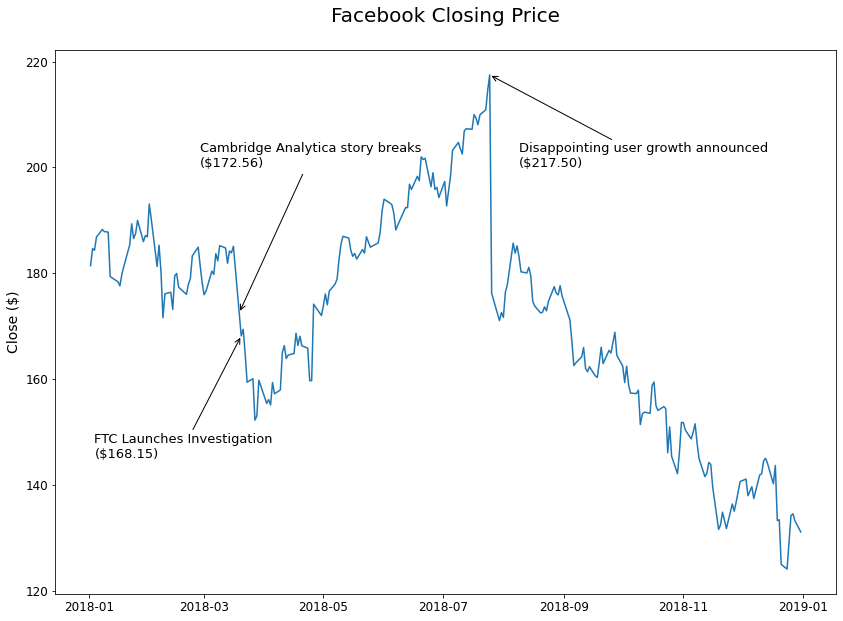

In [492]:
fig, ax = plt.subplots(figsize=(14,10))
sns.lineplot(fb.close)
plt.title("Facebook Closing Price\n", size=20)
plt.xlabel("")
plt.ylabel("Close ($)", size=14)
plt.xticks(fontsize=12)
plt.yticks(size=12)

events = ["Disappointing user growth announced", "Cambridge Analytica story breaks", "FTC Launches Investigation"]

edates = pd.to_datetime(pd.Series(['2018-07-25', '2018-03-19', '2018-03-20']))

textpos = [(15, 200), (-20, 200), (-75, 145)] # 1st num in each tuple is the day offset, 
                                              # the 2nd is the price/y-value where the text should be positioned

for pos in textpos:
    pos[0], pos[1]

for event, edate, pos in zip(events, edates, textpos):
    plt.annotate(
        f'{event}\n(${fb.close[edate]:,.2f})', 
        xy=(edate, fb.close[edate]),
        xytext=(edate + pd.DateOffset(days=pos[0]), pos[1]),
        size=13,
        color='k',
        arrowprops={'arrowstyle': '->'}      
    )

None

## Exercise 6

Modify the `reg_resid_plots()` function to use a `matplotlib` colormap instead of cycling between two colors.   
Remember, for this use case, we should pick a qualitative colormap or make our own.

(I DIDN'T GET THIS ON MY OWN, BUT LOOKED AT THE SOLUTION. NOT WORTH BANGING MY HEAD ON.)

In [545]:
fb_reg_data = fb.assign(log_volume=np.log(fb.volume),
                        max_abs_change=fb.high - fb.low).iloc[:,-3:]

In [546]:
def reg_resid_plots(data): 
    """ 
    Using `seaborn`, plot the regression and residuals plots
    side-by-side for every permutation of 2 columns in data.
    Parameters: 
        - data: A `pandas.DataFrame` object
    Returns:
        A matplotlib `Axes` object. 
    """ 
    
    num_cols = data.shape[1] 
    permutation_count = num_cols * (num_cols - 1) 
    
    
    fig, ax = \
    plt.subplots(permutation_count, 2, figsize=(25, 25))  
    
    for (x, y), axes, color in zip(
        itertools.permutations(data.columns, 2),
        ax,
        [cm.Dark2(i) for i in range(len(ax))] ## COPIED THIS IN FROM THE SOLUTION
    ): 
        for subplot, func in zip(
            axes, (sns.regplot, sns.residplot)
        ):
            func(x=x, y=y, data=data, ax=subplot, color=color) #, cmap='tab20c') #color=color)
            if func == sns.residplot:
                subplot.set_ylabel('residuals')
    return fig.axes

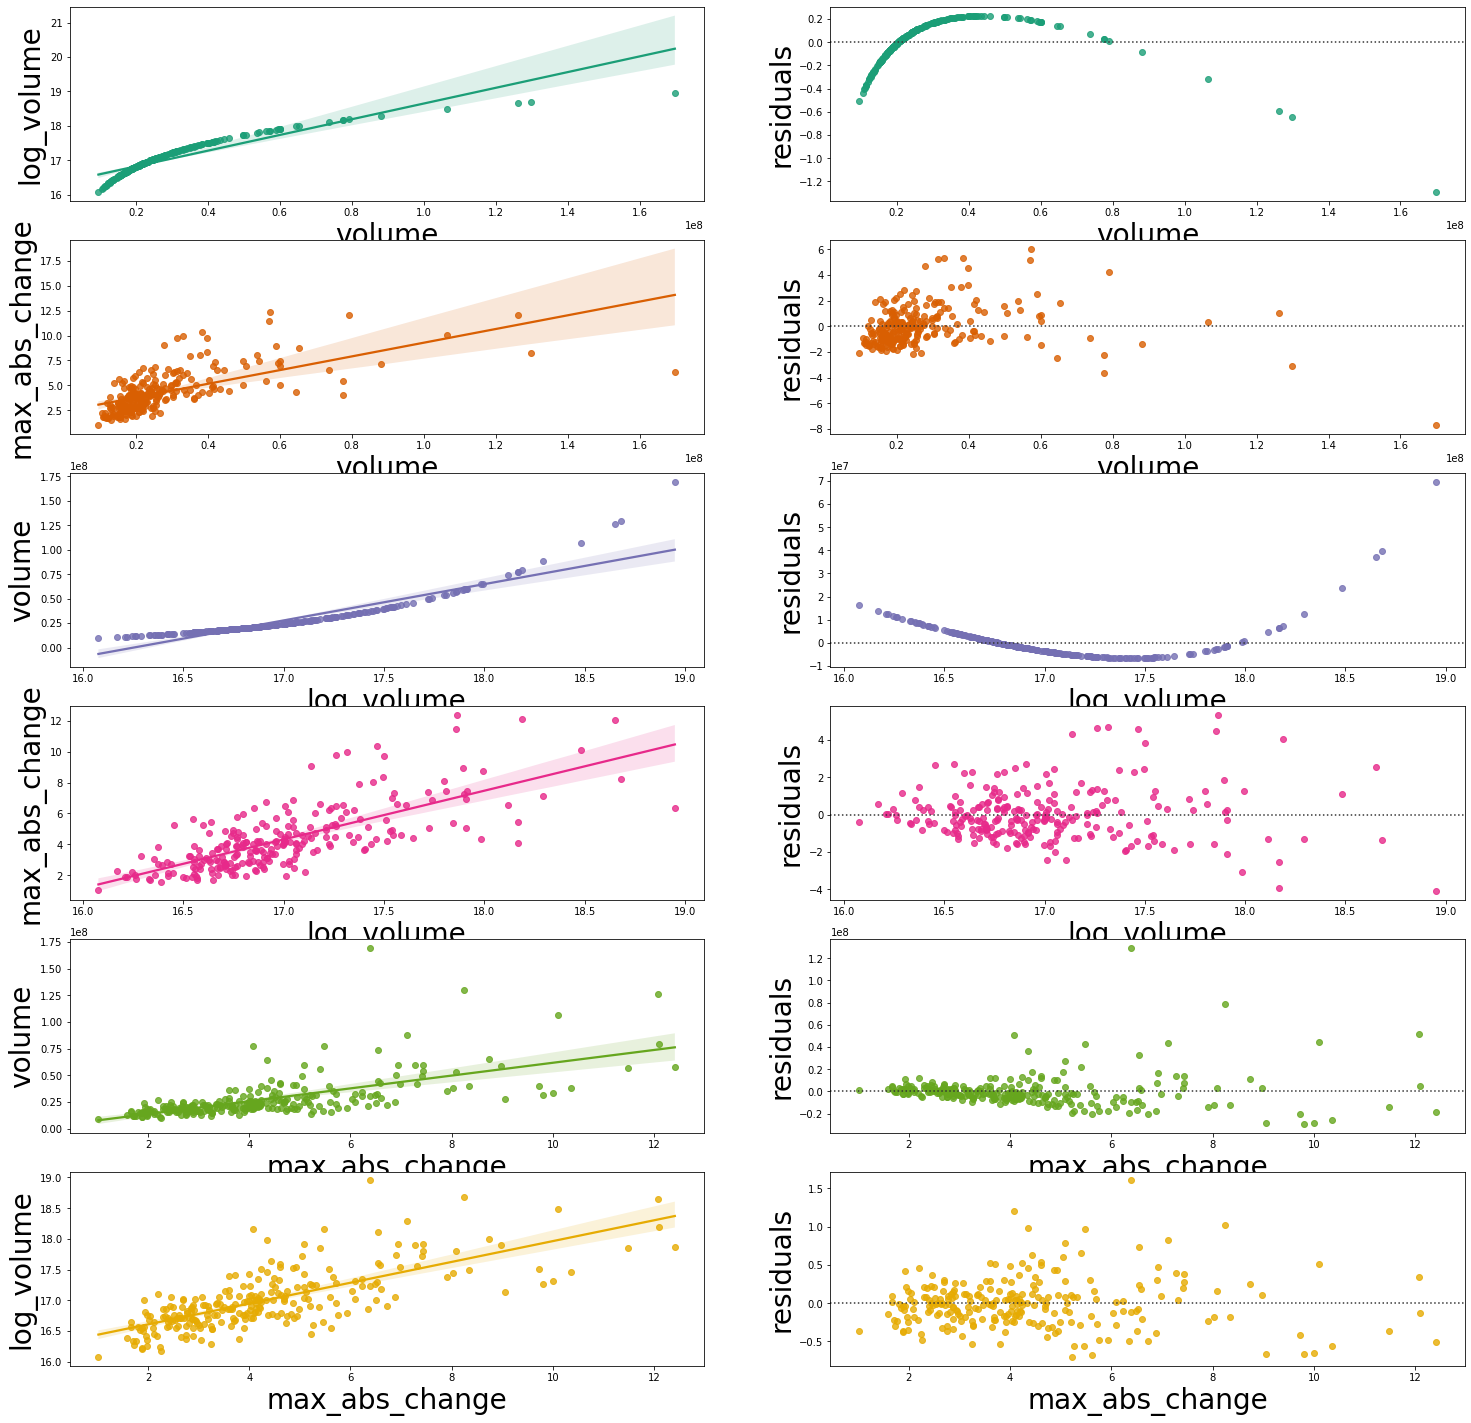

In [547]:
reg_resid_plots(fb_reg_data)
None

#### <span style="color:green">A large digression...How to iteratively figure out the right commands before running to Google... In this case, how to increase the size of the x tick label.</span>

`ax.axes.xaxis` took me a while to figure out. If I'd looked at the list of available attributes and functions it might've allowed me to narrow my search space faster. 

In [437]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)


This gives me an idea of the available attributes. I showed 40 below, but running `dir(ax.axes)` provides the complete list. 

In [439]:
axeslist = dir(ax.axes) # GET COMPLETE LIST OF AVAILABLE ATTRIBUTES

axeslist = random.sample(axeslist, 39) + ['xaxis']  # CHOOSE SUBSET OF AVAILABLE ATTRIBUTES TO PRINT, INSURING xaxis SHOWS UP

axeslist = np.asarray(axeslist).reshape((8, 5)) # CONVERT TO NUMPY ARRAY WITH PRINTABLE DIMENSIONS

axeslist = pd.DataFrame(axeslist) # CONVERT TO PANDAS DATAFRAME

display(pd.DataFrame(axeslist)) # DISPLAY (THIS LEAVES OPEN THE POSSIBILITY OF 2 xaxis DISPLAYED, 
                                # BUT THIS WAS SUPPOSED TO BE QUICK AND DIRTY)

,0,1,2,3,4
0,add_collection,update_from,table,get_xlabel,set_axisbelow
1,set_figure,transAxes,axline,barbs,plot
2,plot_date,tricontour,__module__,_colorbars,get_ymajorticklabels
3,set_label,_update_title_position,errorbar,_callbacks,yaxis
4,get_visible,set_xlabel,axhspan,_request_autoscale_view,get_figure
5,set_xlim,step,get_path_effects,__reduce_ex__,set_title
6,_aspect,__getstate__,set_navigate_mode,_transformSet,set_position
7,get_yticks,sharey,fmt_ydata,_parse_scatter_color_args,xaxis


In theory, I might identify `xaxis` as promising and then repeat what I did above with `ax.axes.xaxis`.

In [440]:
axislist = dir(ax.axes.xaxis) # GET COMPLETE LIST OF AVAILABLE ATTRIBUTES

axislist = random.sample(axislist, 39) + ['xaxis']  # CHOOSE SUBSET OF AVAILABLE ATTRIBUTES TO PRINT, INSURING xaxis SHOWS UP

axislist = np.asarray(axislist).reshape((8, 5)) # CONVERT TO NUMPY ARRAY WITH PRINTABLE DIMENSIONS

axislist = pd.DataFrame(axislist) # CONVERT TO PANDAS DATAFRAME

display(pd.DataFrame(axislist)) # DISPLAY (THIS LEAVES OPEN THE POSSIBILITY OF 2 xaxis DISPLAYED, 
                                # BUT THIS WAS SUPPOSED TO BE QUICK AND DIRTY)



,0,1,2,3,4
0,set_data_interval,get_clip_path,_format_with_dict,_fully_clipped_to_axes,_axes
1,_alpha,__init_subclass__,_copy_tick_props,set_minor_formatter,__lt__
2,set,get_major_locator,set_major_locator,set_units,_reset_major_tick_kw
3,isDefault_minfmt,stale,get_ticklabels,_set_artist_props,majorTicks
4,__repr__,_get_tick,_gid,_set_scale,_tick_class
5,convert_units,_transform,get_units,stale_callback,_animated
6,set_label_text,axis_date,__ne__,_update_props,get_snap
7,update_units,set_clip_on,set_picker,isDefault_majfmt,xaxis


In [410]:
#vars(ax.axes)
#help(ax.axes)

#### [How To Pretty Print Pandas Dataframe – Detailed Guide](https://www.stackvidhya.com/pretty-print-dataframe/)

In [401]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

display(pd.DataFrame(a1))

,0,1,2,3
0,_sharey,name,_children,get_images
1,set_xticklabels,update_from,_update_image_limits,get_adjustable
2,pick,get_xaxis_text2_transform,_picker,_sticky_edges
3,set,get_cursor_data,_set_title_offset_trans,phase_spectrum
4,set_title,get_ygridlines,in_axes,_unstale_viewLim
